In [74]:
import os
import h5py
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.sequence import Sequence
from matplotlib import pyplot as plt
import numpy as np
import datetime
import xmltodict

In [15]:
%matplotlib inline

In [108]:
filename = 'file_brain_AXFLAIR_200_6002425.h5'
fileparts = os.path.splitext(filename)
patientName = fileparts[0]
f = h5py.File(filename,'r')

In [6]:
list(f.keys())

['ismrmrd_header', 'kspace', 'reconstruction_rss']

In [12]:
img = f['reconstruction_rss'][:]

In [14]:
img.shape

(16, 320, 320)

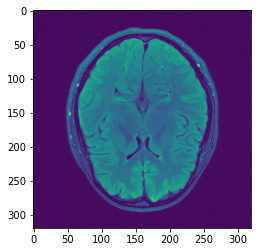

In [17]:
plt.imshow(img[0,:,:])

In [63]:
image_max = 1024
scale = image_max / np.percentile(img, 99.9)
pixels_scaled = np.clip((scale * img[0,:,:]), 0, image_max).astype('int16')


In [64]:
pixels_scaled.max()

1024

In [87]:
head = xmltodict.parse(f['ismrmrd_header'][()])

In [112]:
list(head['ismrmrdHeader']['sequenceParameters'].keys())

['TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing']

In [114]:
reconSpace = head['ismrmrdHeader']['encoding']['reconSpace'] # ['matrixSize', 'fieldOfView_mm']
measurementInformation = head['ismrmrdHeader']['measurementInformation'] # ['measurementID', 'patientPosition', 'protocolName', 'frameOfReferenceUID']
acquisitionSystemInformation = head['ismrmrdHeader']['acquisitionSystemInformation'] # ['systemVendor', 'systemModel', 'systemFieldStrength_T', 'relativeReceiverNoiseBandwidth' 'receiverChannels', 'coilLabel', 'institutionName']
H1resonanceFrequency_Hz = head['ismrmrdHeader']['experimentalConditions']['H1resonanceFrequency_Hz']
sequenceParameters = head['ismrmrdHeader']['sequenceParameters'] # ['TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing']

In [116]:
sequenceParameters['sequence_type']

'TurboSpinEcho'

In [66]:
dcm = pydicom.dcmread('301_from_codify.dcm')

In [67]:
pixels = dcm.pixel_array

In [68]:
pixels.min()

51

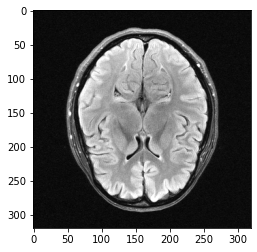

In [72]:
plt.imshow(pixels, cmap='gray')

In [117]:
# File meta info data elements
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
file_meta.MediaStorageSOPInstanceUID = "1.2.3"
file_meta.ImplementationClassUID = "1.2.3.4"
file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'


# Main data elements
ds = Dataset()

dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr
ds.Modality = 'MR'
ds.ModalitiesInStudy = ['', 'PR', 'MR', '']
ds.StudyDescription = measurementInformation['protocolName']

ds.PatientName = patientName # FILL FROM FILENAME
ds.PatientID = patientName # FILL FROM FILENAME
ds.PatientBirthDate = '19700101'
ds.PatientSex = 'M'
ds.PatientAge = '030Y'
ds.PatientIdentityRemoved = 'YES'
ds.MRAcquisitionType = '2D'
ds.SequenceName = sequenceParameters['sequence_type']
ds.SliceThickness = reconSpace['fieldOfView_mm']['z']
ds.RepetitionTime = sequenceParameters['TR']
ds.EchoTime = sequenceParameters['TE'] #FILL FROM XML
ds.ImagingFrequency = H1resonanceFrequency_Hz
ds.ImagedNucleus = '1H'
ds.EchoNumbers = "1"
ds.MagneticFieldStrength = acquisitionSystemInformation['systemFieldStrength_T']
ds.AcquisitionMatrix = [0, 288, 230, 0] #FILL FROM XML
ds.InPlanePhaseEncodingDirection = 'ROW' #FILL FROM XML
ds.FlipAngle = "90.0" #FILL FROM XML
ds.PatientPosition = 'HFS' #FILL FROM XML
ds.RectilinearPhaseEncodeReordering = 'LINEAR' #FILL FROM XML
ds.NumberOfKSpaceTrajectories = 76 #FILL FROM XML
ds.StudyInstanceUID = '9999.201195313229306300504165090941650322040' #
ds.SeriesInstanceUID = '9999.77565704772180596049766113144111491928' #
ds.StudyID = '' #FILL FROM XML
ds.InstanceNumber = "14" #FILL FROM XML/CONTEXT
ds.PatientOrientation = ['0.988018', '0.14265'] # NOT POSSIBLE - CHECK
ds.ImagePositionPatient = [-96.26828, -112.8608, 38.50235] # NOT POSSIBLE - CHECK
ds.ImageOrientationPatient = [0.988018, 0.142657, -0.0589, -0.133943, 0.98216, 0.131983] # NOT POSSIBLE - CHECK
ds.FrameOfReferenceUID = '9999.307577518163987444448414094854502648367'
ds.ImagesInAcquisition = "26" # NOT POSSIBLE - CHECK
ds.SliceLocation = "44.54" # NOT POSSIBLE - CHECK
ds.SamplesPerPixel = 1
ds.PhotometricInterpretation = 'MONOCHROME2'
ds.NumberOfFrames = "1"
ds.Rows = pixels_scaled.shape[1]
ds.Columns = pixels_scaled.shape[0]
ds.PixelSpacing = [0.4296875, 0.4296875] #FILL FROM XML
ds.PixelAspectRatio = [1, 1] #FILL FROM XML
ds.BitsAllocated = 16 #FILL FROM CONVERSION
ds.BitsStored = 12  #FILL FROM CONVERSION
ds.HighBit = 11  #FILL FROM CONVERSION
ds.PixelRepresentation = 1  #FILL FROM CONVERSION
ds.SmallestImagePixelValue = 0  #FILL FROM CONVERSION
ds.LargestImagePixelValue = 1024  #FILL FROM CONVERSION
ds.BurnedInAnnotation = 'NO'
ds.WindowCenter = "213.0"  #FILL FROM CONVERSION
ds.WindowWidth = "426.0" #FILL FROM CONVERSION
ds.LossyImageCompression = '00'
ds.StudyStatusID = 'COMPLETED'
ds.ResultsID = ''


ds.PixelData = pixels_scaled

ds.file_meta = file_meta
ds.is_implicit_VR = False
ds.is_little_endian = True
ds.save_as(r'dicom_generated.dcm', write_like_original=False)

In [32]:
512*512*2

524288